In [75]:
#%matplotlib notebook
import os
import random as rnd
from copy import deepcopy

import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as mcolors
import torch
from PIL import Image  # TODO
from torch.utils.data import Dataset
from skimage import color


In [100]:
class NYUDepthV2Dataset(Dataset):
    __data_dir = os.path.join(os.getcwd(), os.pardir, ".data")
    __set_name = "NYUDepthDatasetV2"
    __set_file = "nyu_depth_v2_labeled.mat"

    def __init__(
        self,
        data_path=None,
        split="train",
        transform=None,
        verbose=True,
        random_seed=42,
    ):
        super().__init__()
        self.data_path = os.path.abspath(
            data_path
            if data_path
            else os.path.join(self.__data_dir, self.__set_name, self.__set_file)
        )
        self.split = split
        self.transform = transform
        self.verbose = verbose

        # Load the .mat f
        with h5py.File(self.data_path, "r") as f:
            # HxWx3XN -> NxHxWx3
            self.rgb_images = np.transpose(f["images"][:100], (0, 3, 2, 1))
            self.depth_maps = np.transpose(f["depths"][:100], (0, 2, 1))
            self.labels = np.transpose(f["labels"][:100], (0, 2, 1))

            chr_arr = [list(f[ref][()].flatten()) for ref in f["names"][0]]
            self.class_names = ["".join(chr(c) for c in name) for name in chr_arr]

        rnd.seed(random_seed)

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        rgb_image = self.rgb_images[idx]
        depth_map = self.depth_maps[idx]
        label = self.labels[idx]

        sample = {"rgb_image": rgb_image, "depth_map": depth_map, "label": label}

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __repr__(self) -> str:
        repr = f"""NYUDepthV2Dataset(split={self.split}, data_path={self.data_path})
        Number of samples: {len(self)}
        Number of labels: {len(self.class_names)}
        RGB image shape: {self.rgb_images.shape}
        Depth map shape: {self.depth_maps.shape}
        Label shape: {self.labels.shape}"""
        return repr

    def visualize_rnd_sample(self):
        sample = self[rnd.randint(0, len(self) - 1)]
        rgb_image = sample["rgb_image"]
        depth_map = sample["depth_map"]
        label = sample["label"]

        # Define a discrete colormap
        # unique_labels = np.unique(label)
        # num_labels = len(unique_labels)
        
        # color_map = color.label2rgb(label)
        # labels = [self.label_id2name(color.rgb2label(color_map)) for color in np.unique(color_map)]

        _, (ax0, ax1, ax2) = plt.subplots(
            1, 3, sharex=True, sharey=True, figsize=(18, 6)
        )
        ax0.imshow(rgb_image)
        ax0.set_title("RGB image")
        ax0.set_axis_off()
        ax1.imshow(depth_map, cmap="hot", interpolation="nearest")
        ax1.set_title("Depth map")
        ax1.set_axis_off()
        # im = ax2.imshow(label, cmap=cmap, norm=norm)
        ax2.imshow(color.label2rgb(label))
        ax2.set_title("Ground truth")
        ax2.set_axis_off()

        # colorbar = plt.colorbar(im, ax=ax2, ticks=unique_labels)
        # colorbar.set_ticklabels([f"{id}:{self.label_id2name(id)}" for id in unique_labels])

        plt.show()


    def split_dataset(self, split=0.8):
        """Split the dataset into two parts with the specified ratio."""
        if split > 1 or split < 0:
            raise ValueError("Split ratio must be between 0 and 1.")
        num_samples = len(self)
        num_samples_train = int(num_samples * split)
        num_samples_val = num_samples - num_samples_train
        train_set, val_set = torch.utils.data.random_split(
            self,
            [num_samples_train, num_samples_val],
            generator=torch.Generator().manual_seed(42),
        )
        return train_set, val_set

    def get_colors(self, num_colors):
        cm = plt.get_cmap("gist_rainbow")
        c_norm = mcolors.Normalize(vmin=0, vmax=num_colors - 1)
        scalar_map = mplcm.ScalarMappable(norm=c_norm, cmap=cm)
        colors = [scalar_map.to_rgba(i) for i in range(num_colors)]
        return colors

    def label_name2id(self, label_name):
        return self.class_names.index(label_name)

    def label_id2name(self, label_id):
        return self.class_names[label_id]

In [101]:
dataset = NYUDepthV2Dataset()
train_set, test_set = dataset.split_dataset()
print(dataset)

NYUDepthV2Dataset(split=train, data_path=/home/jd/repos/semanticsegmentation/.data/NYUDepthDatasetV2/nyu_depth_v2_labeled.mat)
        Number of samples: 100
        Number of labels: 894
        RGB image shape: (100, 480, 640, 3)
        Depth map shape: (100, 480, 640)
        Label shape: (100, 480, 640)


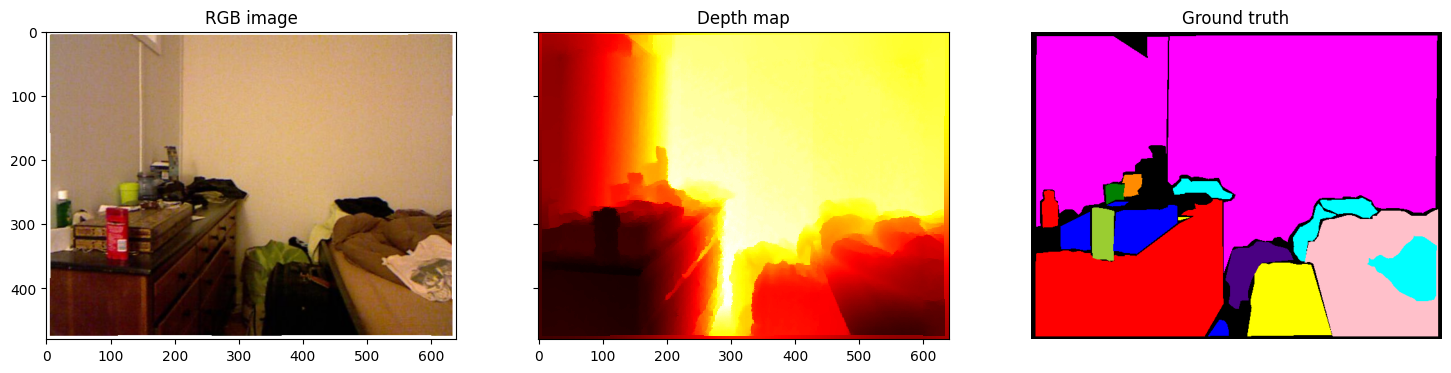

In [102]:
dataset.visualize_rnd_sample()